<a href="https://colab.research.google.com/github/Gooogr/YOLO_Toolkit/blob/imagenet/Train_yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
import os
import fnmatch

import numpy as np
import cv2
import re

from google.colab import files
from google.colab.patches import cv2_imshow

In [2]:
! pip install -q awscli

     |████████████████████████████████| 3.3MB 8.7MB/s 
     |████████████████████████████████| 6.6MB 58.0MB/s 


In [3]:
# Enable GPU
# Check what we get: K80, P100, K4 or T4.
! nvidia-smi

Mon Sep  7 22:30:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8     9W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Constants

In [6]:
CLASS_NAMES = ['Human face', 'Human hand']
SAMPLES_LIMIT = 10 #1000 for one class ~ 1.5 hours

https://stackoverflow.com/questions/35497069/passing-ipython-variables-as-arguments-to-bash-commands<br>
https://stackoverflow.com/questions/61606054/passing-ipython-variables-as-string-arguments-to-shell-command

## Utils

In [7]:
#--- Dataset downloading utils ---
def yolo2voc(data, w, h):
  '''
  Convert boundary box from YOLO format to VOC
  '''
  bbox_width = float(data[3]) * w
  bbox_height = float(data[4]) * h
  center_x = float(data[1]) * w
  center_y = float(data[2]) * h
  x_min = int(center_x - (bbox_width / 2))
  y_min = int(center_y - (bbox_height / 2))
  x_max = int(center_x + (bbox_width / 2))
  y_max = int(center_y + (bbox_height / 2))
  return(x_min, y_min, x_max, y_max)

def show_data_sample(dir_path):
  '''
  Show random sample from dataset with boundary box
  '''
  txt_files = []
  img_files = []
  for txt_file in os.listdir(dir_path):
      if fnmatch.fnmatch(txt_file, '*.txt'):
        txt_files.append(txt_file)
  print('Data pairs amount:', len(txt_files))

  sample_name = txt_files[np.random.randint(len(txt_files))].split('.')[0]

  txt_sample = open(os.path.join(dir_path, sample_name + '.txt'), 'r')
  img_sample = cv2.imread(os.path.join(dir_path, sample_name + '.jpg'))
  height = img_sample.shape[0]
  width = img_sample.shape[1]
  for line in txt_sample.readlines():
      yolo_bndbox = (list(map(float, re.split('\s',line)[0:5])))
      voc_bndbox = yolo2voc(yolo_bndbox, width, height)
      img_sample = cv2.rectangle(img_sample, voc_bndbox[:2], voc_bndbox[2:], color=[255, 0, 0], thickness=2)
  img_sample = cv2.resize(img_sample, (0,0), fx=0.5, fy=0.5)  
  cv2_imshow(img_sample)

## Dataset downloading

In [8]:
def setup_OIDv4Toolkit():
  # Clone tookit for Open Image Dataset v4
  ! git clone https://github.com/theAIGuysCode/OIDv4_ToolKit
  % cd OIDv4_ToolKit
  ! pip install -q -r  requirements.txt

In [9]:
setup_OIDv4Toolkit()

Cloning into 'OIDv4_ToolKit'...
remote: Enumerating objects: 444, done.
remote: Total 444 (delta 0), reused 0 (delta 0), pack-reused 444
Receiving objects: 100% (444/444), 34.09 MiB | 4.25 MiB/s, done.
Resolving deltas: 100% (157/157), done.
/content/OIDv4_ToolKit


In [10]:
class_names_query = r' '.join(name.replace(' ', '_') for name in CLASS_NAMES)

In [11]:
# Don't change --multiclasses key value. YOLO requires that all files be in the same folder
! python3 main.py downloader -y \
 --classes {class_names_query}  \
 --type_csv train \
 --limit {SAMPLES_LIMIT} \
 --multiclasses 1


		   ___   _____  ______            _    _    
		 .'   `.|_   _||_   _ `.         | |  | |   
		/  .-.  \ | |    | | `. \ _   __ | |__| |_  
		| |   | | | |    | |  | |[ \ [  ]|____   _| 
		\  `-'  /_| |_  _| |_.' / \ \/ /     _| |_  
		 `.___.'|_____||______.'   \__/     |_____|
	

             _____                    _                 _             
            (____ \                  | |               | |            
             _   \ \ ___  _ _ _ ____ | | ___   ____  _ | | ____  ____ 
            | |   | / _ \| | | |  _ \| |/ _ \ / _  |/ || |/ _  )/ ___)
            | |__/ / |_| | | | | | | | | |_| ( ( | ( (_| ( (/ /| |    
            |_____/ \___/ \____|_| |_|_|\___/ \_||_|\____|\____)_|    
                                                          
        
    [INFO] | Downloading ['Human face', 'Human hand'] together.
   [ERROR] | Missing the class-descriptions-boxable.csv file.
[DOWNLOAD] | Automatic download.
...145%, 0 MB, 55690 KB/s, 0 seconds passed
[DOWNLOAD] | File 

https://github.com/ipython/ipython/issues/6701

In [16]:
# Custom magic function for passing python variables into files
# Taken from here: https://github.com/ipython/ipython/issues/6701#issuecomment-382640776
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [18]:
# some_variable = "text"

In [19]:
# %%writetemplate filename.txt
# test: {some_variable}

In [12]:
# Convert annotations to normalazied YOLO version. 
with open('classes.txt', 'w') as f:
    for item in CLASS_NAMES:
        f.write("%s\n" % item)

! python convert_annotations.py

Currently in subdirectory: train
Converting annotations for class:  Human face_Human hand
100% 20/20 [00:01<00:00, 15.17it/s]


In [13]:
! pwd

/content/OIDv4_ToolKit


In [15]:
dataset_folder_name = r'_'.join(name for name in CLASS_NAMES)

In [19]:
# Remove old labels. Count files amount in the dataset (images + labels).
# Name of dataset folder corresponds to the selected labels types: <Class name 1>_<Class name 2>_ ...
! rm -r /content/OIDv4_ToolKit/OID/Dataset/train/'{dataset_folder_name}'/Label
! ls /content/OIDv4_ToolKit/OID/Dataset/train/'{dataset_folder_name}'/ | wc -l

40


In [20]:
# Move dataset folder to the root of working directory
! mkdir /content/dataset

# I can't use mv command because of "Argument list too long error"
# Instead of that I will use while loop.
# Read more here: https://www.cyberciti.biz/faq/argument-list-too-long-error-solution/

# ! mv /content/OIDv4_ToolKit/OID/Dataset/train/'Human face_Human hand'/* /content/dataset
! ls -1  /content/OIDv4_ToolKit/OID/Dataset/train/'{dataset_folder_name}'/ | while read file; do mv /content/OIDv4_ToolKit/OID/Dataset/train/'{dataset_folder_name}'/$file /content/dataset ; done

In [21]:
# Check that we succesfully move all files
! ls /content/dataset/ | wc -l

40


Data pairs amount: 20


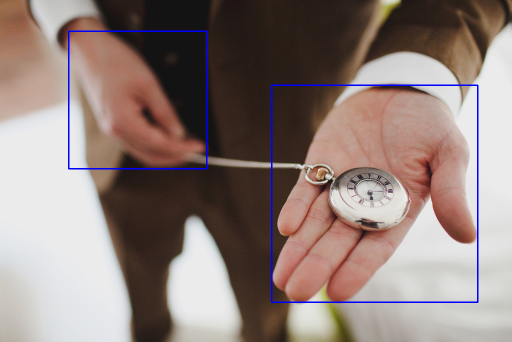

In [24]:
dir_path = '/content/dataset' 
show_data_sample(dir_path)

## Setting up YOLO Darknet

In [ ]:
% cd /content

/content


In [ ]:
def make_darknet():
  '''
  Run this function if darknet wasn`t setted up your root project folder
  '''
  # Clone and  make darknet in My Drive folder. We should prepare all config files there befory copy them to tmp
  ! git clone https://github.com/AlexeyAB/darknet.git

  # Enable GPU learning
  %cd darknet
  !sed -i 's/OPENCV=0/OPENCV=1/' Makefile
  !sed -i 's/GPU=0/GPU=1/' Makefile
  !sed -i 's/CUDNN=0/CUDNN=1/' Makefile
  !sed -i 's/OPENMP=0/OPENMP=1/' Makefile

  # verify CUDA
  !/usr/local/cuda/bin/nvcc --version

  ! make --silent

Check saving rules in ```/content/darknet/src/detector.c```, lines 384 - 403

```
 if (iteration >= (iter_save + 1000) || iteration % 1000 == 0) {
     sprintf(buff, "%s/%s_%d.weights", backup_directory, base, iteration);
 if (iteration >= (iter_save_last + 100) || (iteration % 100 == 0 && iteration > 1)) {
     sprintf(buff, "%s/%s_last.weights", backup_directory, base);
```
Change it if you need, but don't forget to ```! make``` it arter that.



In [ ]:
%%capture
make_darknet()

In [ ]:
def download_pretrained_data(tiny_only=True):
  # YOLOv4
  # cfg files have already been in cfg folder
  if tiny_only == False:
    ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights
    ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.conv.137

  # YOLOv4 tiny
  #! wget --quiet https://raw.githubusercontent.com/AlexeyAB/darknet/master/cfg/yolov4-tiny.cfg
  ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.weights
  ! wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29

  

In [ ]:
download_pretrained_data()

In [ ]:
def predict_sample(tiny=True):
    % cd /content/darknet
    ! chmod 777 ./darknet
    if tiny:
        ! ./darknet detector test cfg/coco.data cfg/yolov4-tiny.cfg yolov4-tiny.weights data/horses.jpg 
    else:
         ! ./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/horses.jpg 
    image = cv2.imread('predictions.jpg')
    cv2_imshow(image)

In [ ]:
# check that we get working YOLO version
predict_sample()

### Prepare config files

In [ ]:
% cd /content/
! wget -c https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/master/splitTrainAndTest.py

/content
--2020-08-28 15:52:15--  https://raw.githubusercontent.com/Gooogr/YOLO_Toolkit/master/splitTrainAndTest.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 657 [text/plain]
Saving to: ‘splitTrainAndTest.py’

splitTrainAndTest.p 100%[===================>]     657  --.-KB/s    in 0s      

2020-08-28 15:52:15 (41.3 MB/s) - ‘splitTrainAndTest.py’ saved [657/657]



In [ ]:
# Create train and test(validate) txt files. Split ratio will be 0.1
! python3 splitTrainAndTest.py /content/dataset

In [ ]:
! mkdir /content/darknet/custom_config_files
% cd /content/darknet/custom_config_files

/content/darknet/custom_config_files


> obj.names

One class - one line. If you make a mistake in the order of the labels, the algorithm will work, but will incorrectly name the detected objects.

In [ ]:
%%writefile obj.names
Human face
Human hand

Writing obj.names


> yolo.data

Specify classes amount. Check pathes to other files:
```
classses = *amount of your classes*
valid  = /content/test.txt
names = /content/darknet/custom_config_files/obj.names
backup = /content/yolo_weights
train  = /content/train.txt
```
We will create backup folder later

In [ ]:
%%writefile yolo.data
classses = 2
valid = /content/test.txt
names =  /content/darknet/custom_config_files/obj.names
backup = /content/yolo_weights
train = /content/train.txt

Writing yolo.data


> yolov4.cfg

How to configure cfg file<br>
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects

In [ ]:
#Generate anchors for cfg file
def generate_anchors():
    % cd /content/darknet
    ! chmod 777 ./darknet
    ! ./darknet detector calc_anchors \
    ./custom_config_files/yolo.data -num_of_clusters 2 -width 416 -height 416 -show


In [ ]:
generate_anchors()

/content/darknet
 CUDA-version: 10010 (10010), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0

 num_of_clusters = 2, width = 416, height = 416 
classes: Using default '1'
 read labels from 17679 images 
 loaded 	 image: 17679 	 box: 59500
 all loaded. 

 calculating k-means++ ...

 iterations = 21 


counters_per_class = 29022, 52466

 avg IoU = 43.52 % 

Saving anchors to the file: anchors.txt 
anchors =  21, 30,  86,112
Unable to init server: Could not connect: Connection refused

(clusters:200872): Gtk-WARNING **: 15:52:49.207: cannot open display: 


DONT FORGET TO ADD THESE ANCHORS TO .CFG FILE!

Download prepaired .cfg file

In [ ]:
% cd /content/darknet/custom_config_files/
! wget -c https://raw.githubusercontent.com/Gooogr/YOLO_Webcam_Tracker/yolov4_tiny/model_files/yolov4-tiny-custom.cfg

/content/darknet/custom_config_files
--2020-08-28 16:32:02--  https://raw.githubusercontent.com/Gooogr/YOLO_Webcam_Tracker/yolov4_tiny/model_files/yolov4-tiny-custom.cfg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2950 (2.9K) [text/plain]
Saving to: ‘yolov4-tiny-custom.cfg’

yolov4-tiny-custom. 100%[===================>]   2.88K  --.-KB/s    in 0s      

2020-08-28 16:32:02 (42.6 MB/s) - ‘yolov4-tiny-custom.cfg’ saved [2950/2950]



In [ ]:
# Create empty directiry for saving weights during the training
! mkdir /content/yolo_weights

### Train YOLOv4

In [ ]:
def train_yolo_from_scratch():
    # Train YOLO
    % cd /content/darknet
    ! ./darknet detector train \
    ./custom_config_files/yolo.data \
    ./custom_config_files/yolov4-tiny-custom.cfg \
    ./yolov4-tiny.conv.29 > /content/temp_train.log -dont_show  

In [ ]:
train_yolo_from_scratch()